# Building a Pet Feeder App

> Workshop at Amrita School of Engineering, Bengaluru

*Kernel Author : Ramshankar Yadhunath*

## Define the Problem Statement

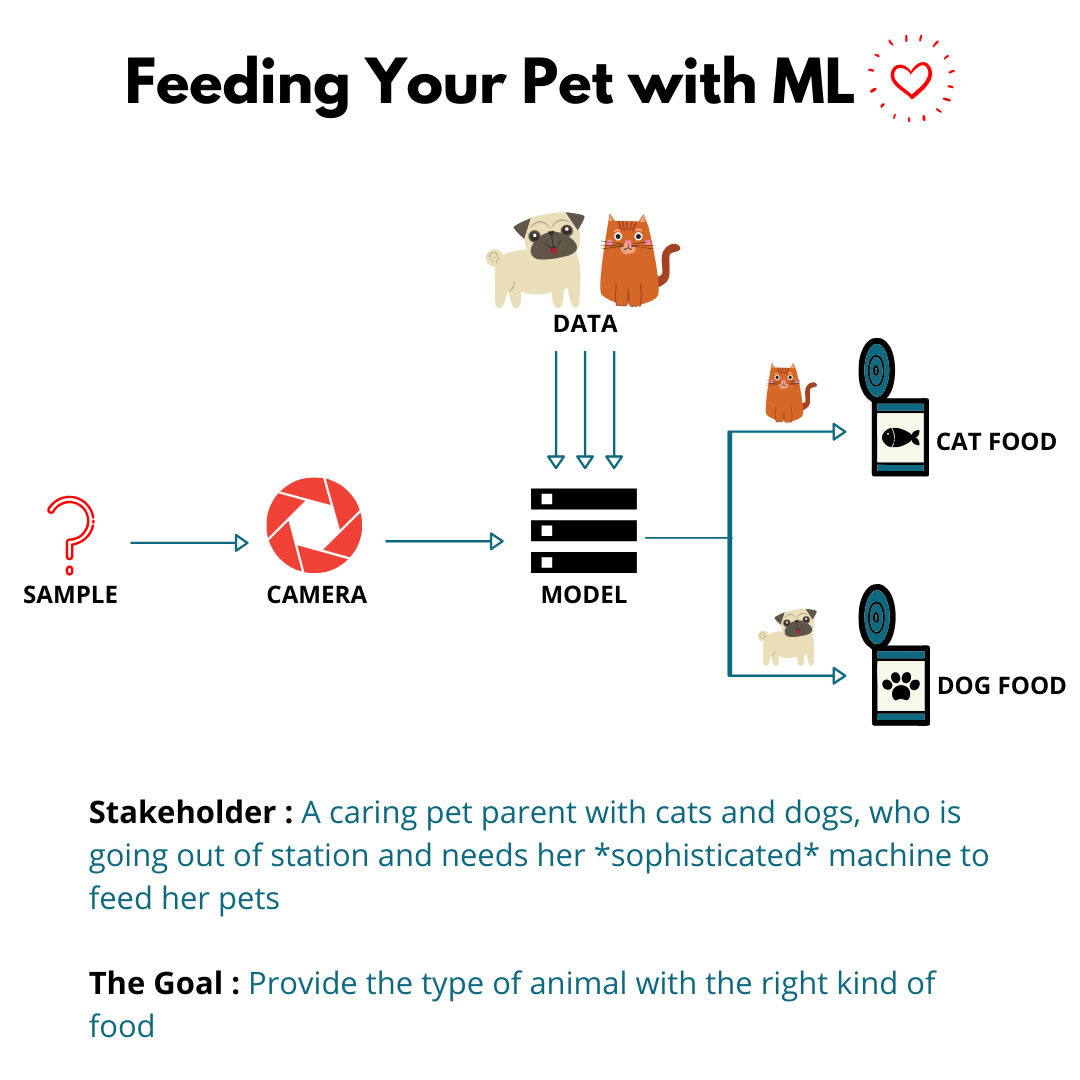

## A Reasonable "Solution"

A reasonable solution in this context is a solution that can satisfy our stakeholder and also be feasible to implement. It's easy to understand that this problem is an **image classification** task. Hence, we shall focus on creating an image classifier that can distinguish between cats and dogs.

### What's the MVP?
MVP stands for minimum viable product. In other words, the [MVP is the product with just enough features for the product to be adopted by innovators or early adopters](https://www.productplan.com/glossary/minimum-viable-product/). Many a times, MVPs are built to test the preliminary version of a product and validate the idea.

In this project, the MVP is a software system that can label an image X as `dog` or `cat` depending upon what X actually contains. And it is an obvious requirement that this system must have a *high accuracy* i.e make as few errors as possible. **(Question: Is a high accuracy enough? Does it not seem like this product needs 100% accuracy? But, is that achievable? Think over this idea for yourself)**

## Building the Classifier

In [ ]:
# import statements

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import load_img

### Loading the Data

In this project, we are lucky as there is already a pre-built dataset of dogs and cats available for us. It is what is already loaded into this kernel.

In [ ]:
def get_labels(folder):
    """
    Extracts the labels of the images
    """
    
    # initialize empty list of labels
    labels = []
    
    for file in folder:
        label = file.split('.')[0]
        if label == 'cat':
            labels.append(0)
        else:
            labels.append(1)
            
    return labels

def get_filenames(folder):
    """
    Extracts the filenames of the images
    """
    
    files = []
    for file in folder:
        files.append(file)
    
    return files

In [ ]:
# load data and data specifics

TRAIN_DIR = '../input/dogs-vs-cats-redux-kernels-edition/train/train'
TEST_DIR = '../input/dogs-vs-cats-redux-kernels-edition/test/test'

! unzip '../input/dogs-vs-cats-redux-kernels-edition/train.zip'

In [ ]:
! unzip '../input/dogs-vs-cats-redux-kernels-edition/test.zip'

In [ ]:
# get train images

tr_images = os.listdir("./train")
print(len(list(tr_images)))  # 25000 should be displayed as that's the size of the training set

te_images = os.listdir("./test")
print(len(list(te_images)))

In [ ]:
# view image

PIL.Image.open(str('train/' + get_filenames(tr_images)[0])) # keep changing the index value to get different images

**What are your observations from these images?**

In [ ]:
# build the image data pipeline

def vectorize_image(filename, label):
    """
    Convert image to array representation
    """
    
    image = tf.image.decode_jpeg(
        tf.io.read_file('train/' + filename),
        channels = 3
    )
    
    # convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    return image, label

def pre_processing(filename, label):
    """
    Perform pre-processing steps
    """
    
    # vectorize image first
    image, label = vectorize_image(filename, label)
    
    # resize images for uniformity
    image = tf.image.resize(image, [126, 126])
    
    # data augmentation (simple horizontal flipping)
    image = tf.image.random_flip_left_right(image)
    
    return image, label

# extract useful information from folders
filenames = get_filenames(tr_images)
labels = get_labels(tr_images)

# split to train and validation set
tr_filenames, val_filenames, tr_labels, val_labels = train_test_split(
    filenames,
    labels,
    train_size = 0.8,
    random_state = 101
)

# make the dataset
train_dataset = tf.data.Dataset.from_tensor_slices((tr_filenames, tr_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
# shuffle it
#dataset = dataset.shuffle(len(filenames))
# perform some pre-processing
#dataset = dataset.map(pre_processing, num_parallel_calls=4)
# set the batch size
#dataset = dataset.batch(batch_size=32)
# prefetch helps introduce parallel training
#dataset = dataset.prefetch(1)

train_dataset = (train_dataset
                 .map(pre_processing, num_parallel_calls=4)
                 .shuffle(len(tr_filenames))
                 .batch(batch_size=32)
                 .prefetch(1)
                )
val_dataset = (val_dataset
               .map(pre_processing, num_parallel_calls=4)
               .shuffle(len(val_filenames))
               .batch(batch_size=32)
               .prefetch(1)
              )

In [ ]:
type(val_dataset)

In [ ]:
tf.test.is_gpu_available()

In [ ]:
# train the model

model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.5),
  layers.Dense(2, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_dataset,
          epochs = 5,
          steps_per_epoch = int(len(tr_filenames)/32), # how many batches to be done before declaring an epoch as done?
          validation_data = val_dataset,
          validation_steps = 10,
          verbose = 2
)

In [ ]:
# save the model; download it

model.save('baseline_model_epoch10_batchsize32.h5')

## Inference

In [ ]:
PIL.Image.open(str('test/' + get_filenames(te_images)[1024]))

In [ ]:
img = tf.io.read_file('test/' + get_filenames(te_images)[1024])
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.convert_image_dtype(img, tf.float32)
img.set_shape([None, None, 3])
img = tf.image.resize(img, (126, 126))
img = np.expand_dims(img, 0) # make 'batch' of 1

pred = model.predict(img)
pred_label_idx = np.argmax(pred) 
labels = ['cat', 'dog']
pred_label = labels[pred_label_idx]
print(f'The given image is most likely the image of a {pred_label}.')